# ONNX 模型

ONNX（Open Neural Network Exchange）是一个开放的深度学习模型格式，旨在促进不同深度学习框架之间的互操作性。ONNX 允许你在不同的框架和工具之间共享和转移模型，而不需要重新训练。它使得模型能够在多个平台、硬件设备和框架中高效地运行。 (ChatGPT 4o)

GitHub: [onnx/onnx](https://github.com/onnx/onnx)

In [1]:
import torch
import numpy as np
import onnxruntime as ort

import mlp
import utils

from sklearn.preprocessing import LabelEncoder

In [2]:
DATA_PATH = 'data'
TITANIC_FN = 'train_and_test2.csv'
MLP_ONNX_FN = 'mlp.onnx'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. 模型准备

为了有一个模型可供推理。这里用 MLP 在 [titanic](https://www.kaggle.com/datasets/heptapod/titanic/data) 数据集上训练 20 个 epochs 产出的模型作为推理服务模型。

In [3]:
csv_path = utils.gen_abspath(DATA_PATH, TITANIC_FN)
df = utils.read_csv(csv_path)
df

,Passengerid,Age,Fare,Sex,sibsp,zero,zero.1,zero.2,zero.3,zero.4,...,zero.12,zero.13,zero.14,Pclass,zero.15,zero.16,Embarked,zero.17,zero.18,2urvived
0,1,22.0,7.2500,0,1,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,0
1,2,38.0,71.2833,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0.0,0,0,1
2,3,26.0,7.9250,1,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,1
3,4,35.0,53.1000,1,1,0,0,0,0,0,...,0,0,0,1,0,0,2.0,0,0,1
4,5,35.0,8.0500,0,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,28.0,8.0500,0,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,0
1305,1306,39.0,108.9000,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0.0,0,0,0
1306,1307,38.5,7.2500,0,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,0
1307,1308,28.0,8.0500,0,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,0


In [4]:
# df.info()

### 1）预处理

In [5]:
# 对类别特征做预处理
label_encoder = LabelEncoder()
df['new_embarked'] = label_encoder.fit_transform(df['Embarked'])

# 将所有特征压缩成向量
features = df[['Age', 'Fare', 'Sex', 'sibsp', 'Parch', 'Pclass', 'new_embarked']].values
features_tensor = torch.tensor(features, dtype=torch.float32)

df['embedding'] = [e for e in df[['Age', 'Fare', 'Sex', 'sibsp', 'Parch', 'Pclass', 'new_embarked']].values]
# df[['embedding', '2urvived']]

### 2）原生模型

train_loss: 0.0146
train_acc: 0.7584
test_acc: 0.7519


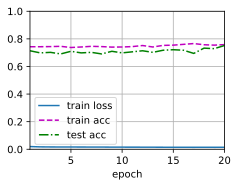

In [6]:
# 原生模型
mlp_model = mlp.SimpleMLP(
    input_channel=df.iloc[0]['embedding'].shape[0],
    output_channel=2,
    hidden_layers=[64, 32],
    dropout_probs=[0.4, 0.2],
    batch_size=32,
    num_epochs=20,
    ylim=[0.0, 1.0],
    test_size=0.2,
    random_state=31
)

predict, metrics = mlp_model(
    df=df,
    embd_col_name='embedding',
    label_col_name='2urvived'
)

print(f'train_loss: {metrics['train_loss']:.4f}')
print(f'train_acc: {metrics['train_acc']:.4f}')
print(f'test_acc: {metrics['test_acc']:.4f}')

In [7]:
df['predict'] = predict
mask = df['2urvived'] != df['predict']
df[mask][['embedding', '2urvived', 'predict']]

,embedding,2urvived,predict
2,"[26.0, 7.925, 1.0, 0.0, 0.0, 3.0, 2.0]",1,0
8,"[27.0, 11.1333, 1.0, 0.0, 2.0, 3.0, 2.0]",1,0
15,"[55.0, 16.0, 1.0, 0.0, 0.0, 2.0, 2.0]",1,0
17,"[28.0, 13.0, 0.0, 0.0, 0.0, 2.0, 2.0]",1,0
19,"[28.0, 7.225, 1.0, 0.0, 0.0, 3.0, 0.0]",1,0
...,...,...,...
1293,"[22.0, 59.4, 1.0, 0.0, 1.0, 1.0, 0.0]",0,1
1298,"[50.0, 211.5, 0.0, 1.0, 1.0, 1.0, 0.0]",0,1
1300,"[3.0, 13.775, 1.0, 1.0, 1.0, 3.0, 2.0]",0,1
1302,"[37.0, 90.0, 1.0, 1.0, 0.0, 1.0, 1.0]",0,1


### 3）使用 torch.nn.Module

train_loss: 0.0024
train_acc: 0.7358
test_acc: 0.7455


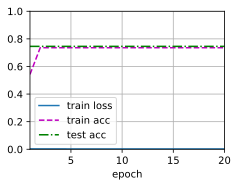

In [8]:
net = mlp.MLP(
    input_channel=df.iloc[0]['embedding'].shape[0],
    output_channel=2,
    hidden_layers=[64, 32],
    dropout_probs=[0.4, 0.2]
)

tm_model = mlp.TrainMLP(net=net)
predict, metrics = tm_model(
    df=df,
    embd_col_name='embedding',
    label_col_name='2urvived'
)

print(f'train_loss: {metrics['train_loss']:.4f}')
print(f'train_acc: {metrics['train_acc']:.4f}')
print(f'test_acc: {metrics['test_acc']:.4f}')

In [9]:
df['predict'] = predict
mask = df['2urvived'] != df['predict']
df[mask][['embedding', '2urvived', 'predict']]

,embedding,2urvived,predict
1,"[38.0, 71.2833, 1.0, 1.0, 0.0, 1.0, 0.0]",1,0
2,"[26.0, 7.925, 1.0, 0.0, 0.0, 3.0, 2.0]",1,0
3,"[35.0, 53.1, 1.0, 1.0, 0.0, 1.0, 2.0]",1,0
8,"[27.0, 11.1333, 1.0, 0.0, 2.0, 3.0, 2.0]",1,0
9,"[14.0, 30.0708, 1.0, 1.0, 0.0, 2.0, 0.0]",1,0
...,...,...,...
875,"[15.0, 7.225, 1.0, 0.0, 0.0, 3.0, 0.0]",1,0
879,"[56.0, 83.1583, 1.0, 0.0, 1.0, 1.0, 0.0]",1,0
880,"[25.0, 26.0, 1.0, 0.0, 1.0, 2.0, 2.0]",1,0
887,"[19.0, 30.0, 1.0, 0.0, 0.0, 1.0, 2.0]",1,0


In [10]:
tm_model.net

MLP(
  (net): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)

## 2. 导出 ONNX

In [11]:
# 构造样例输入
features = df['embedding'].iloc[0].astype(np.float32)
tensor_features = torch.tensor(features).unsqueeze(0).to(device)
example_inputs = (tensor_features, )
example_inputs

(tensor([[22.0000,  7.2500,  0.0000,  1.0000,  0.0000,  3.0000,  2.0000]],
        device='cuda:0'),)

In [12]:
# mlp onnx 输出文件路径
mlp_onnx_path = utils.gen_abspath(DATA_PATH, MLP_ONNX_FN)

# 导出 MLP 模型
torch.onnx.export(
    model=tm_model.net,  # 模型
    args=example_inputs,  # 模型输入样例
    f=mlp_onnx_path,  # 输出文件名
    export_params=True,  # 导出模型参数
    opset_version=20,  # ONNX 操作集版本
    input_names=['x'],  # 输入名
    output_names=['predict'],  # 输出名
    dynamic_axes={
        'x': {0: 'batch_size'},  # 第 0 维是动态的（batch_size）
        'predict': {0: 'batch_size'}
    }
)

In [13]:
# 验证 onnx 模型
mlp_session = ort.InferenceSession(mlp_onnx_path)
outputs = mlp_session.run(None, {
    "x": tensor_features.cpu().numpy()
})
outputs

[array([[ 0.70658803, -0.7039464 ]], dtype=float32)]